# Introduction

Do not spend too much time trying to get very tiny metrics improvement. Once you have a model with a correct predictive power, you should better spend time explaining your data cleaning & preparation pipeline as well as explanations & visualizations of the results.

The goal is to see your fit with our company culture & engineering needs, spending 50h on an over-complicated approach will not give you bonus points compared to a simple, yet effective, to-the-point solution.

## About the data

The dataset you will be working with is called Emo-DB and can be found [here](http://emodb.bilderbar.info/index-1280.html).

It is a database containing samples of emotional speech in German. It contains samples labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information")
   
The goal of this project is to develop a model which is able to **classify samples of emotional speech**. Feel free to use any available library you would need, but beware of re-using someone else's code without mentionning it!

## Deliverable

The end-goal is to deliver us a zip file containing:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work
* A Dockerfile which defines a container for the project. The container should handle everything (download the data, run the code, etc...). When running the container it should expose the jupyter notebook on one port and expose a Flask API on another one. The Flask app contains two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* A README.md which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* Any necessary .py, .sh or other files needed to run your code.

```
    AUTHOR: Niclas Simmler
    DATE: April 22-29, 2021
```

# Libraries Loading

First, we will need to do some basic setup. We will activate autoreload and make sure the src code is visible in jupyter.

In [41]:
%load_ext autoreload
%autoreload 2
%config Application.log_level="INFO"
import os
import sys

PROJECT_BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA_BASE_PATH = os.path.join(PROJECT_BASE_PATH, 'data')
MODEL_BASE_PATH = os.path.join(PROJECT_BASE_PATH, 'model')
SRC_BASE_PATH = os.path.join(PROJECT_BASE_PATH, 'src')
sys.path.insert(0, SRC_BASE_PATH)

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's load our required modules.

We start of with our very own `ser` module. This one will hold all relevant functionalities.

In [2]:
import ser
from ser.utils import one_hot_encode, plot_conf_mat, score_clf, plot_history

Next, we will load some other common modules which we need.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import cm
from pydub import AudioSegment
from pydub.playback import play
from pydub.utils import db_to_float, ratio_to_db
import matplotlib.pyplot as plt
from speechpy.feature import mfcc
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV

# Data Preparation & Cleaning

## Download

We will first need to download the data if not already done so. In order to deal with all the logic, a wrapper class will be used, which allows for easy operation on the dataset.

The code for the dataset wrapper can be found in `src/ser/dataset.py`. First, instantiate a dataset object.

In [4]:
dataset = ser.Dataset(data_path=DATA_BASE_PATH, remote_url='http://emodb.bilderbar.info/download/download.zip')

2021-04-24 16:45:03,131 - ser.dataset - INFO - Creating Dataset Wrapper object.
2021-04-24 16:45:03,132 - ser.dataset - INFO - > Base Path at "/Users/nik/Code/visium/data"
2021-04-24 16:45:03,133 - ser.dataset - INFO - > Pristine Path at "/Users/nik/Code/visium/data/pristine"
2021-04-24 16:45:03,134 - ser.dataset - INFO - > Working Path at "/Users/nik/Code/visium/data/working"
2021-04-24 16:45:03,134 - ser.dataset - INFO - Make sure that the http://emodb.bilderbar.info/download/download.zip points to a ZIP file.


In [5]:
# Run this line below if you want to clean the data directory
#dataset.clean()

Then we download the data.

In [6]:
dataset.download()

2021-04-24 16:45:03,228 - ser.dataset - INFO - Dataset downloaded.


True

The return value of the download is `True`, thus, everything went fine. If we were to rerun this function, it would not download anything anymore. However, using the `force=True` argument, we can initiate the download again.

Since it is a ZIP File, we will need to extract it.

In [7]:
dataset.extract()

2021-04-24 16:45:03,279 - ser.dataset - INFO - Dataset extracted.


True

The extraction went well too. If we were to rerun this function, it would not extract anything anymore. However, using the `force=True` argument, we can initiate the extraction again.

Now we need to parse the data. For this, let's have a look at the documentation (http://www.emodb.bilderbar.info/index-1280.html)

In our data folder, we have multiple files and folders. Not all of them are relevant.

In [8]:
print(os.listdir(os.path.join(DATA_BASE_PATH, 'working')))
print(os.listdir(os.path.join(DATA_BASE_PATH, 'working', 'wav'))[:10])

['wav', '.gitkeep', 'silb', 'erklaerung.txt', 'lablaut', 'erkennung.txt', 'labsilb']
['16a02Lb.wav', '14a07Wc.wav', '10a07Ad.wav', '13a05Ea.wav', '14a05Wa.wav', '14a07Na.wav', '15a05Wa.wav', '16b10Wb.wav', '09a01Nb.wav', '16a01Fc.wav']


For the task at hand, only the content of the `wav` folder are relevant. It contains wav-files that are named in the following schema (according to the documentation.

```
Positions 1-2: number of speaker
Positions 3-5: code for text
Position 6: emotion (sorry, letter stands for german emotion word)
Position 7: if there are more than two versions these are numbered a, b, c ....
```

The documentation further states information about the speakers:

```
03 - male, 31 years old
08 - female, 34 years
09 - female, 21 years
10 - male, 32 years
11 - male, 26 years
12 - male, 30 years
13 - female, 32 years
14 - female, 35 years
15 - male, 25 years
16 - female, 31 years
```

And about the spoken sample:

|code|text (german)|try of an english translation|
|--- |--- |--- |
|a01|Der Lappen liegt auf dem Eisschrank.|The tablecloth is lying on the frigde.|
|a02|Das will sie am Mittwoch abgeben.|She will hand it in on Wednesday.|
|a04|Heute abend könnte ich es ihm sagen.|Tonight I could tell him.|
|a05|Das schwarze Stück Papier befindet sich da oben neben dem Holzstück.|The black sheet of paper is located up there besides the piece of timber.|
|a07|In sieben Stunden wird es soweit sein.|In seven hours it will be.|
|b01|Was sind denn das für Tüten, die da unter dem Tisch stehen?|What about the bags standing there under the table?|
|b02|Sie haben es gerade hochgetragen und jetzt gehen sie wieder runter.|They just carried it upstairs and now they are going down again.|
|b03|An den Wochenenden bin ich jetzt immer nach Hause gefahren und habe Agnes besucht.|Currently at the weekends I always went home and saw Agnes.|
|b09|Ich will das eben wegbringen und dann mit Karl was trinken gehen.|I will just discard this and then go for a drink with Karl.|
|b10|Die wird auf dem Platz sein, wo wir sie immer hinlegen.|It will be in the place where we always store it.|

And lastly, some information about the emotions:

|letter|emotion (english)|letter|emotion (german)|
|--- |--- |--- |--- |
|A|anger|W|Ärger (Wut)|
|B|boredom|L|Langeweile|
|D|disgust|E|Ekel|
|F|anxiety/fear|A|Angst|
|H|happiness|F|Freude|
|S|sadness|T|Trauer|

Note: `N` is also an option which stands for `Neutral`.

So, the sample `16a02Lb.wav` can be parsed as the following:

* Speaker = 16 - female, 31 years
* Text = a02 for "Das will sie am Mittwoch abgeben."
* Emotion = L for "Langeweile"
* Version = b (i.e., there is at least another version a in the dataset)


In [9]:
speakers = ['03', '08', '09', '10', '11', '12', '13', '14', '15', '16']
texts = ['a01', 'a02', 'a04', 'a05', 'a07', 'b01', 'b02', 'b03', 'b09', 'b10']
emotions = {
    'W': 'Ärger (Wut)',
    'L': 'Langeweile',
    'E': 'Ekel',
    'A': 'Angst',
    'F': 'Freude',
    'T': 'Trauer',
    'N': 'Neutral'
}
files = list()
for filename in os.listdir(os.path.join(dataset.working_path, 'wav')):
    assert len(filename) == 11, 'Encountered unknown filename.'
    _speaker = filename[0:2]
    assert _speaker in speakers, 'Encountered unknown speaker.'
    _text = filename[2:5]
    assert _text in texts, 'Encountered unknown text.'
    _emotion = filename[5:6]
    assert _emotion in emotions.keys(), 'Encountered unknown emotion.'
    _version = filename[6:7]
    assert _version in list('abcdefghijklmnopqrstuvwxyz'), 'Encountered unknown version.'
    files.append({
        'filename': filename,
        'full_path': os.path.join(dataset.working_path, 'wav', filename),
        'speaker': _speaker, 
        'text': _text,
        'emotion': _emotion,
        'version': _version
    })
print(files[:5])

[{'filename': '16a02Lb.wav', 'full_path': '/Users/nik/Code/visium/data/working/wav/16a02Lb.wav', 'speaker': '16', 'text': 'a02', 'emotion': 'L', 'version': 'b'}, {'filename': '14a07Wc.wav', 'full_path': '/Users/nik/Code/visium/data/working/wav/14a07Wc.wav', 'speaker': '14', 'text': 'a07', 'emotion': 'W', 'version': 'c'}, {'filename': '10a07Ad.wav', 'full_path': '/Users/nik/Code/visium/data/working/wav/10a07Ad.wav', 'speaker': '10', 'text': 'a07', 'emotion': 'A', 'version': 'd'}, {'filename': '13a05Ea.wav', 'full_path': '/Users/nik/Code/visium/data/working/wav/13a05Ea.wav', 'speaker': '13', 'text': 'a05', 'emotion': 'E', 'version': 'a'}, {'filename': '14a05Wa.wav', 'full_path': '/Users/nik/Code/visium/data/working/wav/14a05Wa.wav', 'speaker': '14', 'text': 'a05', 'emotion': 'W', 'version': 'a'}]


In order to get a more manageable interface for the samples, the `Sample` class is meant to interface a sample and deals with all low level operations.

In [10]:
s = ser.Sample(os.path.join(dataset.working_path, 'wav', '14a07Wc.wav'))
print(s)

<Sample name=14a07Wc.wav, path=/Users/nik/Code/visium/data/working/wav/14a07Wc.wav, length=None, sample_rate=None, speaker=14, gender=Female, text=a07, emotion=W, version=c, chunk=1>


As this seems to work, the dataset function `.prepare()` is meant to automate this.

In [11]:
dataset.prepare()
print(dataset.get_raw_data()[:2])

2021-04-24 16:45:03,494 - ser.dataset - INFO - Dataset prepared.
[<Sample name=16a02Lb.wav, path=/Users/nik/Code/visium/data/working/wav/16a02Lb.wav, length=None, sample_rate=None, speaker=16, gender=Female, text=a02, emotion=L, version=b, chunk=1>, <Sample name=14a07Wc.wav, path=/Users/nik/Code/visium/data/working/wav/14a07Wc.wav, length=None, sample_rate=None, speaker=14, gender=Female, text=a07, emotion=W, version=c, chunk=1>]


In [12]:
print(len(dataset.get_raw_data()))

535


We got 535 samples in total. This is not an awful lot to work with. Thus, we might use some data augmentation method later on to increase the sample amount.

# Feature Engineering

As a next step, we will need to load the actual data. We need to keep in mind that the samples might be of different lengths. We have two options here: Either cut all samples to the smallest size OR padd all samples to the longest size. Since, we do not have that much data, it makes sense to not further reduce the dataset. Thus, we will apply some padding. But first, let's load some samples and see with what we are dealing with.

In [13]:
samples = dataset.get_raw_data()[:10]
for sample in samples:
    audio = AudioSegment.from_wav(sample.get('path'))
    print(audio.frame_rate, len(audio), audio)

16000 2081 <pydub.audio_segment.AudioSegment object at 0x14328b198>
16000 2064 <pydub.audio_segment.AudioSegment object at 0x14328b240>
16000 1603 <pydub.audio_segment.AudioSegment object at 0x14328b2e8>
16000 4196 <pydub.audio_segment.AudioSegment object at 0x14328b358>
16000 4007 <pydub.audio_segment.AudioSegment object at 0x14328b240>
16000 2096 <pydub.audio_segment.AudioSegment object at 0x14328b390>
16000 3098 <pydub.audio_segment.AudioSegment object at 0x14328b3c8>
16000 2522 <pydub.audio_segment.AudioSegment object at 0x14328b438>
16000 1683 <pydub.audio_segment.AudioSegment object at 0x14328b4a8>
16000 2096 <pydub.audio_segment.AudioSegment object at 0x14328b518>


As we can see (second column), the files have a lot of different lengths. Thus, the padding is really necessary.

In [14]:
loaded_samples = list()
sample_lengths = list()
for sample in dataset.get_raw_data():
    audio = AudioSegment.from_wav(sample.get('path'))
    loaded_samples.append((audio.frame_rate, audio))
    sample_lengths.append(len(audio))

In [15]:
avg_length = int(round(sum(sample_lengths)/len(sample_lengths), 0))
print(f'Min length: {min(sample_lengths)}, Max length: {max(sample_lengths)}, Avg length: {avg_length}')

Min length: 1226, Max length: 8978, Avg length: 2780


Text(0.5, 0, 'Sample length [ms]')

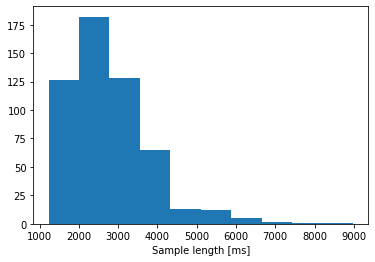

In [16]:
plt.clf()
plt.hist(sample_lengths)
plt.xlabel('Sample length [ms]')

The length of the samples varies quite a lot. I expected it to be more densly packed. Given the fact that we are not dealing with an awful lot of data and that the sample lengths vary quite a lot, we will need to be careful when padding/slicing the audio. Since, we intend to use techniques such as MFCCs (Mel-frequency cepstral coefficients), the length of the sample is quite decisive. Too short and too long of a sample (i.e., < 1s and > few seconds) might not catch all features. Thus, we will proceed in the following manner:

* Split each sample into chunk of length `min(sample_lengths)` (= this length might be a hyper-parameter for finetuning)
* Create new samples based on additional chunks
* Pad the last sample with silence

This way we will end up with a lot more samples (which is good, since we haven't had that many samples to start with). The last sample might not be really helpful in case it only contains a few milliseconds of information and is padded with a lot of noise.

It is worth noting: It might be that our length is too small, thus we would need to be able to increase this length and fine tune. We will consult research later on to find an ideal length candidate.

In [17]:
def split_and_pad(sample, length):
    sample_length = len(sample)
    delta = length - sample_length
    chunks = list()
    if delta < 0: # sample needs splitting
        chunks.extend(sample[::length])
    else:
        chunks.append(sample)
    # pad the last chunk
    last_chunk = chunks[-1]
    to_pad = length - len(last_chunk)
    padding = AudioSegment.silent(duration=to_pad, frame_rate=last_chunk.frame_rate)
    # combine the samples and also make sure we really do not exceed the length due to rounding issues
    chunks[-1] = last_chunk.append(padding, crossfade=0)[:length]
    return chunks

In [18]:
for i, chunk in enumerate(split_and_pad(loaded_samples[1][1], min(sample_lengths))):
    print(f'Playing chunk #{i+1}')
    play(chunk)

Playing chunk #1
Playing chunk #2


Another thing of concern might be the normalization. We are dealing with audio samples from Male and Female, spoken in different emotions and of different sentences. Naturally, the audio amplitude will vary based on the source. Thus, it seems relevant to normalize the audio prior to feature extraction to achieve an unbiased representation.

Let's have a look at a few examples:

In [19]:
def plot_wave_form(samples):
    fig, axs = plt.subplots(len(samples), 1, figsize=(10, 3*len(samples)))
    fig.tight_layout(pad=3.0)
    for ax, sample in zip(axs, samples):
        audio_buffer = np.frombuffer(sample.get_array_of_samples(), dtype=np.int16)
        audio_len = len(sample)
        time = np.linspace(0, audio_len, num = len(audio_buffer))
        ax.plot(time, audio_buffer)
        ax.set_title(f'Length: {audio_len}, Amplitude Max: {sample.max}, Amplitude Max DB: {sample.max_dBFS}')
    plt.show()

In [20]:
male = None
female = None
first_text = None
# Find a female and male sample
for sample in dataset.get_raw_data():
    if male is not None and female is not None:
        break
    if sample.get('speaker') in ['03', '10', '11', '12', '15']:
        if first_text is None or sample.get('text') != first_text:
            if male is None:
                male = AudioSegment.from_wav(sample.get('path'))
        else:
            continue
    else:
        if first_text is None or sample.get('text') != first_text:
            if female is None:
                female = AudioSegment.from_wav(sample.get('path'))
        else:
            continue

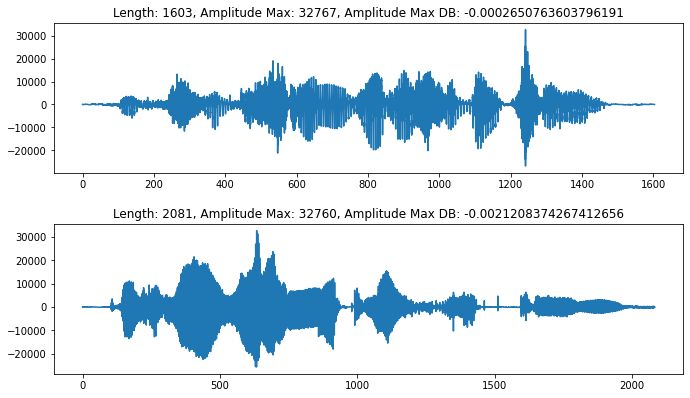

In [21]:
plot_wave_form([male, female])

It does not appear to be a crazy difference in amplitude. But better be safe than sorry.

In [22]:
def find_peak_amplitude(samples):
    max_value = -np.inf
    max_dbfs = -np.inf
    for _, sample in samples:
        max_value = sample.max if max_value < sample.max else max_value
        max_dbfs = sample.max_dBFS if max_dbfs < sample.max_dBFS else max_dbfs
    return (max_value, max_dbfs)
        
max_value, max_dbfs = find_peak_amplitude(loaded_samples)

In [23]:
def normalize(sample, max_value, headroom=0.1):
    """Normalize function.
    Based on implementation of pydub: https://github.com/jiaaro/pydub/blob/master/pydub/effects.py#L36-L49
    """
    target_peak = sample.max_possible_amplitude * db_to_float(-headroom)
    needed_boost = ratio_to_db(target_peak / max_value)
    return sample.apply_gain(needed_boost)

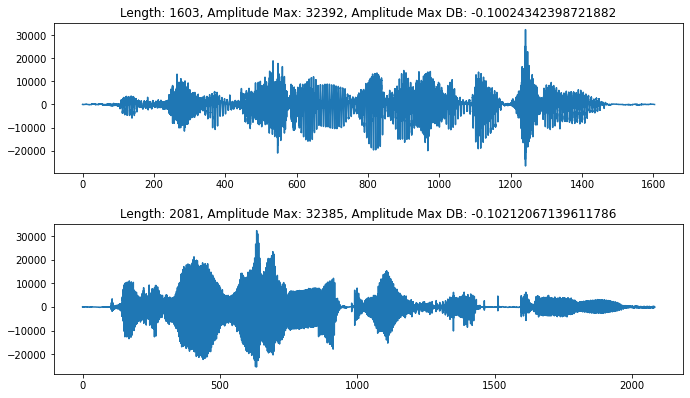

In [24]:
plot_wave_form([normalize(sample, max_value) for sample in [male, female]])

Unfortunately, the normalization does not make much of a difference (the numbers only differ because we applied some headroom). However, in light of a possible application with unseen data, the normalization step is mandatory for data samples outside of the dataset. Furthermore, the Emo-DB dataset was recorded in a professional recording studio [1]. We can expect quite good audio processing from the samples.

The dataset function `.load()` is meant to automate this whole process.

In [25]:
#avg = lambda x: int(round(sum(x)/len(x), 0))
dataset.load(split_at=min)

2021-04-24 16:45:08,282 - ser.dataset - INFO - Normalizing requested.
2021-04-24 16:45:08,400 - ser.dataset - INFO - Dataset loaded.


True

In [26]:
print('Samples: ', len(dataset.get_loaded_data()))
dataset.get_loaded_data()[:10]

Samples:  1484


[<Sample name=16a02Lb.wav, path=/Users/nik/Code/visium/data/working/wav/16a02Lb.wav, length=1226, sample_rate=16000, speaker=16, gender=Female, text=a02, emotion=L, version=b, chunk=1>,
 <Sample name=16a02Lb.wav, path=/Users/nik/Code/visium/data/working/wav/16a02Lb.wav, length=1226, sample_rate=16000, speaker=16, gender=Female, text=a02, emotion=L, version=b, chunk=2>,
 <Sample name=14a07Wc.wav, path=/Users/nik/Code/visium/data/working/wav/14a07Wc.wav, length=1226, sample_rate=16000, speaker=14, gender=Female, text=a07, emotion=W, version=c, chunk=1>,
 <Sample name=14a07Wc.wav, path=/Users/nik/Code/visium/data/working/wav/14a07Wc.wav, length=1226, sample_rate=16000, speaker=14, gender=Female, text=a07, emotion=W, version=c, chunk=2>,
 <Sample name=10a07Ad.wav, path=/Users/nik/Code/visium/data/working/wav/10a07Ad.wav, length=1226, sample_rate=16000, speaker=10, gender=Male, text=a07, emotion=A, version=d, chunk=1>,
 <Sample name=10a07Ad.wav, path=/Users/nik/Code/visium/data/working/wav/

We now have a lot more samples, plus, we can also see with the `chunk` information, that we have multiple samples for the same file if it exceeds the length specified for the split. Also, all samples are now of the same length.

Next up, is the feature extraction. Here in lies the actual work. According to various research [2, 3, 4] , a common feature is the MFCC.
I will first implement the MFCC but will make it modular so we can easily extend it later on.
Thankfully, the MFCC extraction is implemented in the `speechpy` library. Since we are using pydub.AudioSegments, we will first need to convert them to format that is understandable by speechpy.


In [27]:
samples = dataset.get_loaded_data()[3:5]
samples

[<Sample name=14a07Wc.wav, path=/Users/nik/Code/visium/data/working/wav/14a07Wc.wav, length=1226, sample_rate=16000, speaker=14, gender=Female, text=a07, emotion=W, version=c, chunk=2>,
 <Sample name=10a07Ad.wav, path=/Users/nik/Code/visium/data/working/wav/10a07Ad.wav, length=1226, sample_rate=16000, speaker=10, gender=Male, text=a07, emotion=A, version=d, chunk=1>]

In [28]:
def extract_coefficients(samples, coefficients=13):
    fig, axs = plt.subplots(len(samples), 1, figsize=(15,1*len(samples)), sharey=True)
    #fig.tight_layout(pad=3.0)
    mfccs = list()
    for ax, sample in zip(axs, samples):
        np_chunk = np.frombuffer(sample.get('object').get_array_of_samples(), dtype=np.int16)
        mel_coefficients = mfcc(np_chunk, sample.get('sample_rate'), num_cepstral=coefficients)
        mfccs.append(np.ravel(mel_coefficients)) # we flatten the data
        mfcc_data = np.swapaxes(mel_coefficients, 0, 1) # we are swapping axis for horizontal visualization
        cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower') 
        ax.set_ylabel('Coefficients')
    fig.suptitle('MFCC', fontsize='20')
    plt.xlabel('Time')
    plt.show()
    print('Coefficients Shape:', mfccs[0].shape)
    return mfccs

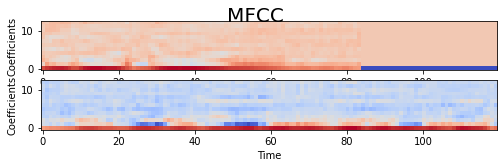

Coefficients Shape: (1560,)


In [29]:
mfccs = extract_coefficients(samples)

This particular sample's MFCC look a bit weird, as we have a lot of activity in the first chunk, but almost nothing in the second one. Let's listen whether this makes sense. (Hint: Yes it does)
Also, we can see the padding in the second half of the second subplot.

One thing to note: The coefficients parameter defines the num_cepstral in the mfcc function. In research, between 10-20 is considered a good amount of features for speech analysis [5]. Obviously, the higher the number, the more "depth" we will gain in the features, but it will also make our models more complex (which is not good).

In [30]:
for i, sample in enumerate(samples):
    print(f'Playing chunk #{i+1}')
    play(sample.get('object'))

Playing chunk #1
Playing chunk #2


Another set of features we should not let go to waste are the information regarding the gender and spoken text. Both feature subset will be one-hot encoded.

The dataset function `.feature_extract()` is meant to automate this whole process of feature extraction. It can also easily be extended as demonstrated below.

We will first only extract the features of gender and spoken text. After that I will demonstrate how easily extendable the feature extraction process is by re-exctracting the features including the MFCCs.

In [31]:
dataset.feature_extract(
    extraction_methods={'SpeakerAndGenderAndTextType': (ser.SpeakerAndGenderAndTextTypeFeatureExtractor, {'speaker':True, 'gender': True, 'text': True})}
)
print('Features:', dataset.get_features()[0].shape)

2021-04-24 16:45:11,859 - ser.dataset - INFO - Now extracting features using SpeakerAndGenderAndTextType Feature Extractor
2021-04-24 16:45:11,920 - ser.dataset - INFO - Feature extracted.
Features: (1484, 22)


In [32]:
dataset.feature_extract(
    extraction_methods={
        'SpeakerAndGenderAndTextType': (ser.SpeakerAndGenderAndTextTypeFeatureExtractor, {'speaker':True, 'gender': True, 'text': True}), 
        'MFCC': (ser.MFCCFeatureExtractor, {'num_cepstral':13})
    },
    force=True
)
print('Features:', dataset.get_features()[0].shape)

2021-04-24 16:45:11,971 - ser.dataset - INFO - Forcing feature extraction. Flushes X, y variable.
2021-04-24 16:45:11,972 - ser.dataset - INFO - Now extracting features using SpeakerAndGenderAndTextType Feature Extractor
2021-04-24 16:45:12,044 - ser.dataset - INFO - Now extracting features using MFCC Feature Extractor
2021-04-24 16:45:17,734 - ser.dataset - INFO - Feature extracted.
Features: (1484, 1582)


### Closing notes on features:

Additional features could be:

* Mel Spectrogram (could be used to feed a CNN)
* Spectral Contrast as seen in [6]

# Modeling & Results & Visualizations

After the feature extraction, a couple of modeling approaches come to mind. Let's start by having a look at a basic classifier.

In [33]:
X, y = dataset.get_features()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

We will first test a basic classifier to get a good feeling. We are dealing with an awful lot of features, thus we will be applying PCA prior to the training.
For the training we will be using a sklearn Pipeline with GridSearchCV to find some hyper-parameters.

In [34]:
pca = PCA()
rf = ser.RandomForestClassifier(save_path=MODEL_BASE_PATH)

pipe = Pipeline(steps=[('pca', pca), ('rf', rf)])

param_grid = {
    'pca__n_components': [10, 50, 100, 500, 1000, X_train.shape[1]],
    'rf__n_estimators': [10, 30, 100]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2)
search.fit(X_train, y_train)
print(f'Best parameter (CV score={search.best_score_:.3f}): {search.best_params_}')

2021-04-24 16:36:35,838 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name n09efabgq9HRg8uV.
2021-04-24 16:36:35,841 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name QVtekaFaDW0BiHOh.
2021-04-24 16:36:35,858 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name g2KeT1xvhaTcelbN.
2021-04-24 16:36:35,863 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name JEQOJmgXOuJe5q9M.
2021-04-24 16:36:35,865 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name zG28r9jBNWArKXmV.
2021-04-24 16:36:35,866 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name OLq84Ddq16WI88vv.
2021-04-24 16:36:35,868 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name hyDTBYQ7d6oDDy3l.
2021-04-24 16:36:35,869 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name QAd6yyiS7I44V1ae.
2021-04-24 16:36:35,871 - ser.model - IN

By the way, we can save and load models.

In [35]:
search.best_estimator_.named_steps['rf'].save_model()

2021-04-24 16:36:50,317 - ser.model - INFO - Saved to /Users/nik/Code/visium/model/WSN9qOz2DBPIeyPL.pkl


In [36]:
model = ser.RandomForestClassifier.load_from_name(save_path=MODEL_BASE_PATH, name='crnVnUNy3aqLrzRZ')

2021-04-24 16:36:50,376 - ser.model - INFO - Instantiated a SERRandomForestClassifier model with name crnVnUNy3aqLrzRZ.


So we have found the best combination of hyperparameters. Let's get the best model and score it.

<Figure size 432x288 with 0 Axes>

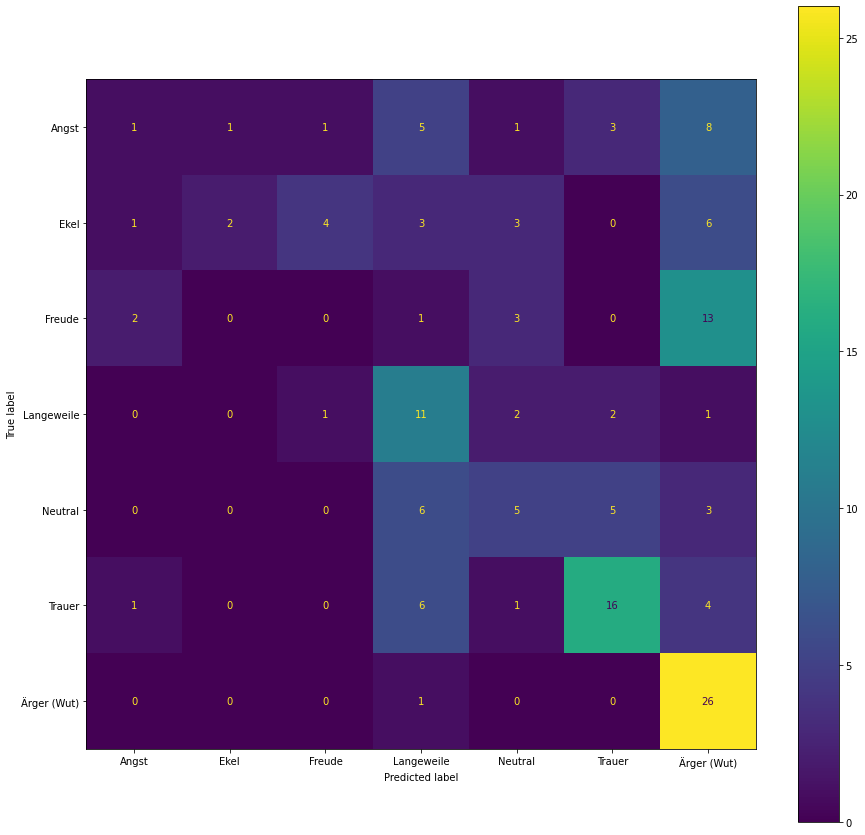

              precision    recall  f1-score   support

       Angst       0.20      0.05      0.08        20
        Ekel       0.67      0.11      0.18        19
      Freude       0.00      0.00      0.00        19
  Langeweile       0.33      0.65      0.44        17
     Neutral       0.33      0.26      0.29        19
      Trauer       0.62      0.57      0.59        28
 Ärger (Wut)       0.43      0.96      0.59        27

    accuracy                           0.41       149
   macro avg       0.37      0.37      0.31       149
weighted avg       0.39      0.41      0.34       149



In [37]:
score_clf(clf=search, X_test=X_test, y_test=y_test, clazzes_mapping=emotions)

We are ok for "Wut", "Trauer", "Langeweile", but not at all good in predicting "Freude" (we are confusing it with "Wut").
Let's try a different model. A notorisously good model is XGBoost.

In [38]:
pca = PCA()
xgb = ser.XGBoostClassifer(save_path=MODEL_BASE_PATH)

pipe = Pipeline(steps=[('pca', pca), ('xgb', xgb)])

param_grid = {
    'pca__n_components': [10, 50, 100, 500, 1000, X_train.shape[1]]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=2)
search.fit(X_train, y_train)
print(f'Best parameter (CV score={search.best_score_:.3f}): {search.best_params_}')

2021-04-24 16:36:51,116 - ser.model - INFO - Instantiated a SERXGBoostClassifier model with name x3LwgsPSGvEd2PSE.
2021-04-24 16:36:51,121 - ser.model - INFO - Instantiated a SERXGBoostClassifier model with name AEUnZfPSIDJoqqdm.
2021-04-24 16:36:51,126 - ser.model - INFO - Instantiated a SERXGBoostClassifier model with name AOI0gxO6uJkkItKF.
2021-04-24 16:36:51,127 - ser.model - INFO - Instantiated a SERXGBoostClassifier model with name eLsOyReo2ulW75VO.
2021-04-24 16:36:51,129 - ser.model - INFO - Instantiated a SERXGBoostClassifier model with name mi1VYlmoB1hwROKa.
2021-04-24 16:36:51,131 - ser.model - INFO - Instantiated a SERXGBoostClassifier model with name dyHATm388swQwTBT.
2021-04-24 16:36:51,133 - ser.model - INFO - Instantiated a SERXGBoostClassifier model with name g36gkiX210YZcKWM.
2021-04-24 16:36:51,135 - ser.model - INFO - Instantiated a SERXGBoostClassifier model with name zx12OCiUOKKjaIMH.
2021-04-24 16:36:51,137 - ser.model - INFO - Instantiated a SERXGBoostClassifier

/Users/nik/.pyenv/versions/3.6.11/lib/python3.6/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:37:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "save_path" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:37:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameter (CV score=0.393): {'pca__n_components': 100}


<Figure size 432x288 with 0 Axes>

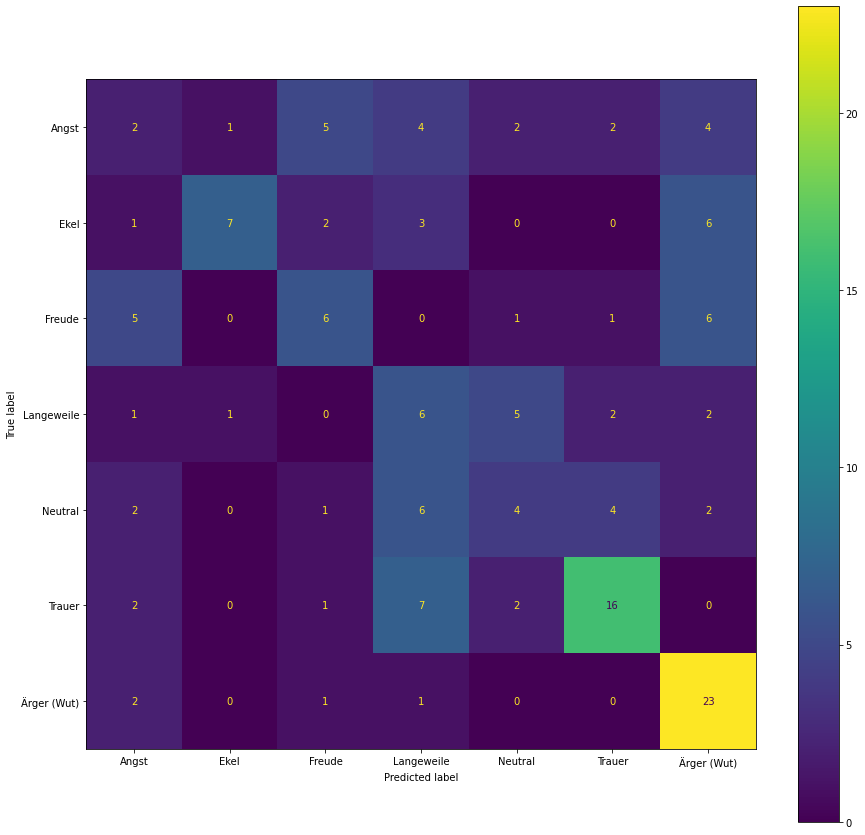

              precision    recall  f1-score   support

       Angst       0.13      0.10      0.11        20
        Ekel       0.78      0.37      0.50        19
      Freude       0.38      0.32      0.34        19
  Langeweile       0.22      0.35      0.27        17
     Neutral       0.29      0.21      0.24        19
      Trauer       0.64      0.57      0.60        28
 Ärger (Wut)       0.53      0.85      0.66        27

    accuracy                           0.43       149
   macro avg       0.42      0.40      0.39       149
weighted avg       0.44      0.43      0.42       149



In [39]:
score_clf(search, X_test, y_test, clazzes_mapping=emotions)

This looks a bit more promising. What's striking, we do confuse "Freude" and "Ekel" with "Wut".

We can do better. Let's use a Keras Model (simple fully connected model). We will not apply PCA for this one. Since a KerasClassifier uses One Hot Encoding for the training data, we will also need to one hot encode the validation target.

In [34]:
ker = ser.KerasClassifier(save_path=MODEL_BASE_PATH, build_fn=lambda: ser.KerasClassifier.build(len(emotions), 0.001, X_train.shape[1]), epochs=20, batch_size=32, verbose=0)
y_test_onehot = one_hot_encode(y_test, emotions.keys())
hist = ker.fit(X_train, y_train, validation_data=(X_test, y_test_onehot))

2021-04-24 16:47:14,774 - ser.model - INFO - Instantiated a SERKerasClassifier model with name A8asoQ22L9IeX2vP.
2021-04-24 16:47:14,836 - ser.model - INFO - Model: "sequential"
2021-04-24 16:47:14,837 - ser.model - INFO - _________________________________________________________________
2021-04-24 16:47:14,837 - ser.model - INFO - Layer (type)                 Output Shape              Param #   
2021-04-24 16:47:14,838 - ser.model - INFO - =================================================================
2021-04-24 16:47:14,838 - ser.model - INFO - dense (Dense)                (None, 100)               158300    
2021-04-24 16:47:14,839 - ser.model - INFO - _________________________________________________________________
2021-04-24 16:47:14,840 - ser.model - INFO - dense_1 (Dense)              (None, 7)                 707       
2021-04-24 16:47:14,840 - ser.model - INFO - =================================================================
2021-04-24 16:47:14,841 - ser.model - INFO - 

<Figure size 432x288 with 0 Axes>

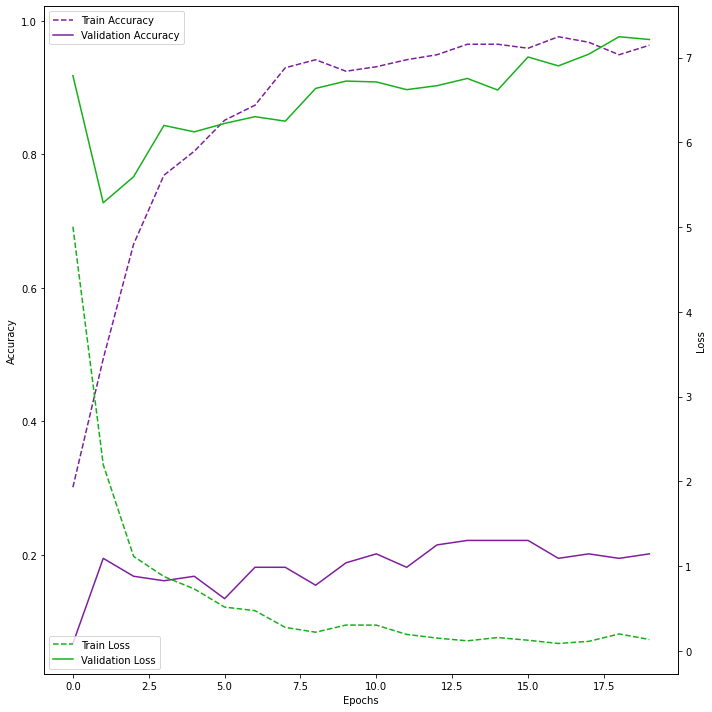

In [35]:
plot_history(hist)

From the loss curves, I would argue that our model does not generalize really well.

2021-04-24 16:47:19,181 - tensorflow - WARNING - From /Users/nik/.pyenv/versions/3.6.11/lib/python3.6/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py:241: Sequential.predict_classes (from tensorflow.python.keras.engine.sequential) is deprecated and will be removed after 2021-01-01.
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

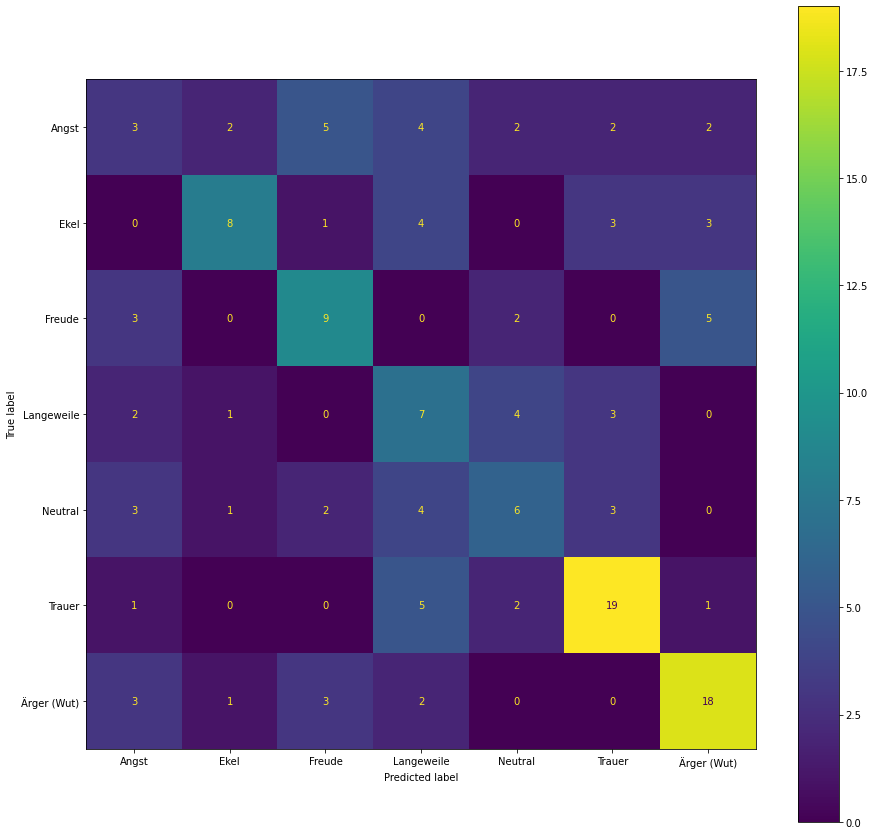

              precision    recall  f1-score   support

       Angst       0.20      0.15      0.17        20
        Ekel       0.62      0.42      0.50        19
      Freude       0.45      0.47      0.46        19
  Langeweile       0.27      0.41      0.33        17
     Neutral       0.38      0.32      0.34        19
      Trauer       0.63      0.68      0.66        28
 Ärger (Wut)       0.62      0.67      0.64        27

    accuracy                           0.47       149
   macro avg       0.45      0.45      0.44       149
weighted avg       0.47      0.47      0.47       149



In [36]:
score_clf(ker, X_test, y_test, clazzes_mapping=emotions, is_from_gridsearch=False)

Let's see whether we can save and restore a Keras Model.

In [37]:
ker.save_model()

2021-04-24 16:47:22,250 - ser.model - INFO - Saved to /Users/nik/Code/visium/model/A8asoQ22L9IeX2vP.pkl


In [39]:
ker2 = ser.KerasClassifier.load_from_name(MODEL_BASE_PATH, 'A8asoQ22L9IeX2vP', build_fn=lambda: ser.KerasClassifier.build(len(emotions), 0.001, X_train.shape[1]), epochs=20, batch_size=32, verbose=0)

2021-04-24 16:47:48,601 - ser.model - INFO - Instantiated a SERKerasClassifier model with name A8asoQ22L9IeX2vP.


<Figure size 432x288 with 0 Axes>

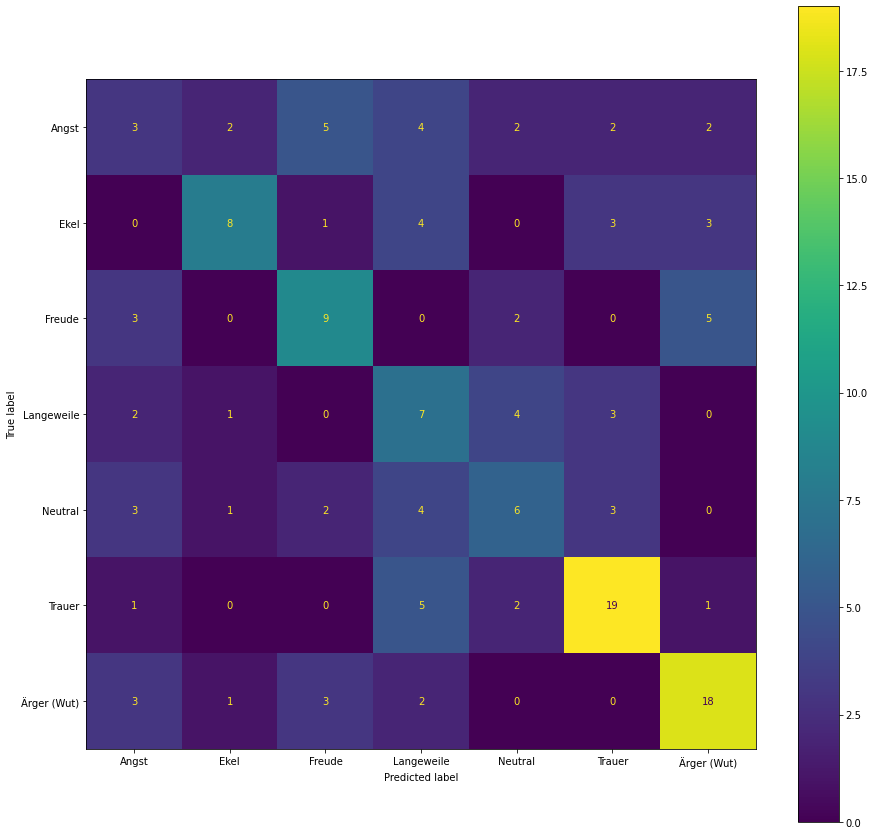

              precision    recall  f1-score   support

       Angst       0.20      0.15      0.17        20
        Ekel       0.62      0.42      0.50        19
      Freude       0.45      0.47      0.46        19
  Langeweile       0.27      0.41      0.33        17
     Neutral       0.38      0.32      0.34        19
      Trauer       0.63      0.68      0.66        28
 Ärger (Wut)       0.62      0.67      0.64        27

    accuracy                           0.47       149
   macro avg       0.45      0.45      0.44       149
weighted avg       0.47      0.47      0.47       149



In [40]:
score_clf(ker2, X_test, y_test, clazzes_mapping=emotions, is_from_gridsearch=False)

Let's use Dropout in the network to see whether it generalizes better on unseen data.

In [43]:
kerdrop = ser.KerasDropoutClassifier(save_path=MODEL_BASE_PATH, build_fn=lambda: ser.KerasDropoutClassifier.build(len(emotions), 0.001, X_train.shape[1]), epochs=100, batch_size=32, verbose=0)
y_test_onehot = one_hot_encode(y_test, emotions.keys())
histdrop = kerdrop.fit(X_train, y_train, validation_data=(X_test, y_test_onehot))

2021-04-24 16:24:43,155 - ser.model - INFO - Instantiated a SERKerasDropoutClassifier model with name McBrrt2L5g7f9x8y.
2021-04-24 16:24:43,196 - ser.model - INFO - Model: "sequential_1"
2021-04-24 16:24:43,197 - ser.model - INFO - _________________________________________________________________
2021-04-24 16:24:43,197 - ser.model - INFO - Layer (type)                 Output Shape              Param #   
2021-04-24 16:24:43,198 - ser.model - INFO - =================================================================
2021-04-24 16:24:43,198 - ser.model - INFO - dropout (Dropout)            (None, 1582)              0         
2021-04-24 16:24:43,199 - ser.model - INFO - _________________________________________________________________
2021-04-24 16:24:43,199 - ser.model - INFO - dense_2 (Dense)              (None, 100)               158300    
2021-04-24 16:24:43,200 - ser.model - INFO - _________________________________________________________________
2021-04-24 16:24:43,201 - ser.model 

<Figure size 432x288 with 0 Axes>

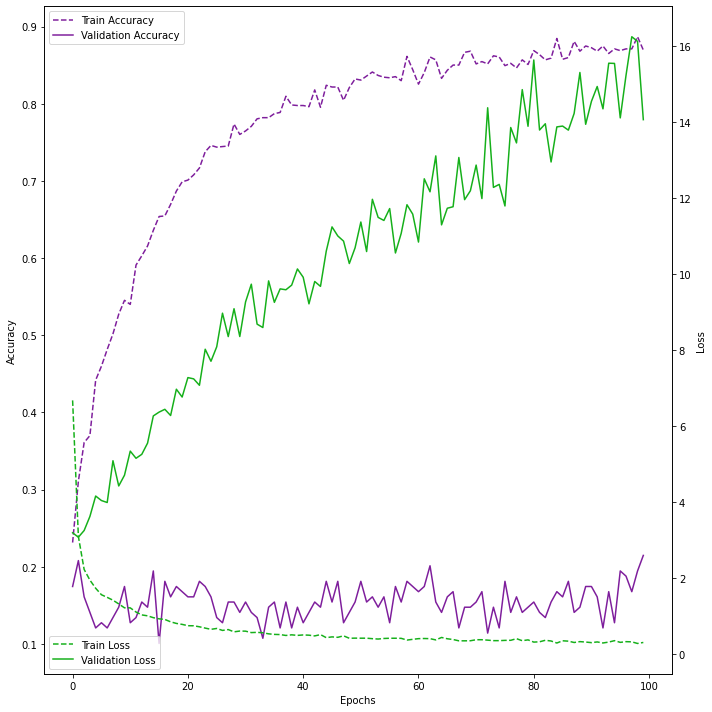

In [44]:
plot_history(histdrop)

<Figure size 432x288 with 0 Axes>

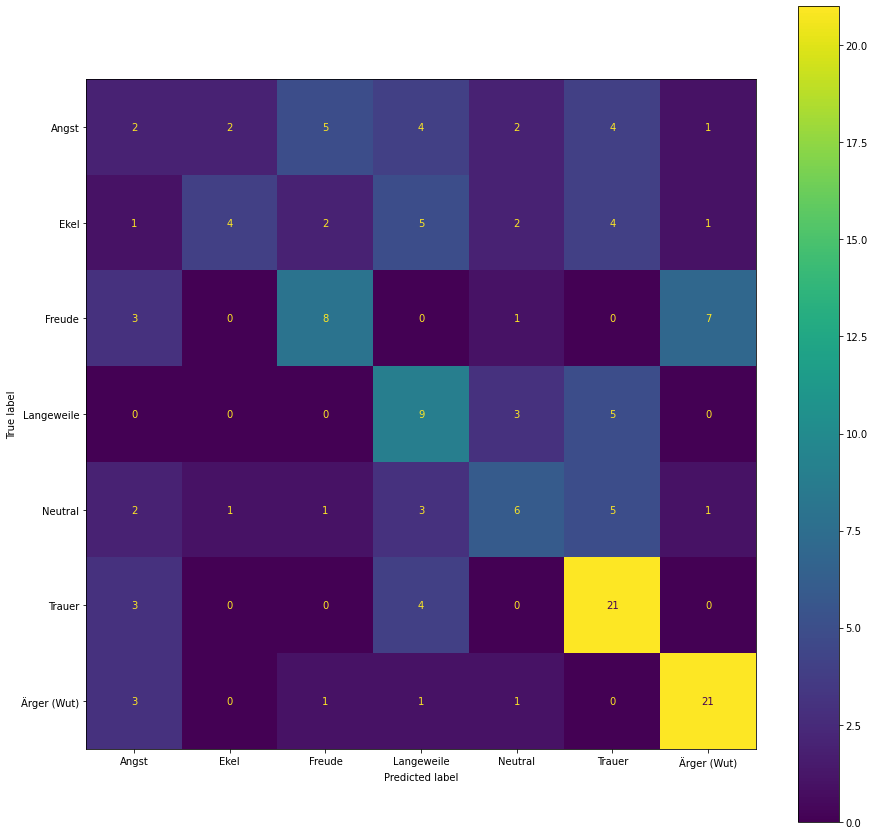

              precision    recall  f1-score   support

       Angst       0.14      0.10      0.12        20
        Ekel       0.57      0.21      0.31        19
      Freude       0.47      0.42      0.44        19
  Langeweile       0.35      0.53      0.42        17
     Neutral       0.40      0.32      0.35        19
      Trauer       0.54      0.75      0.63        28
 Ärger (Wut)       0.68      0.78      0.72        27

    accuracy                           0.48       149
   macro avg       0.45      0.44      0.43       149
weighted avg       0.47      0.48      0.45       149



In [45]:
score_clf(kerdrop, X_test, y_test, clazzes_mapping=emotions, is_from_gridsearch=False)

Despite being a little better in classification according to the F1 Scores (and visually), we still can't fix the issue with confusing "Freude" with "Wut".

# API

Now we can build our API. The idea is to have an easy possibility to test different configurations.

# Bonus

As a bonus, let's try to classify a custom spoken sample.

# References

[1] Burkhardt, F., Paeschke, A., Rolfes, M., Sendlmeier, W. F., & Weiss, B. (2005). A database of German emotional speech. In Ninth European Conference on Speech Communication and Technology.

[2] Sezgin, M.C., Gunsel, B. & Kurt, G.K. Perceptual audio features for emotion detection. J AUDIO SPEECH MUSIC PROC. 2012, 16 (2012). https://doi.org/10.1186/1687-4722-2012-16

[3] Ayadia ME, Kamelb MS, Karrayb F: Survey on speech emotion recognition: features, classification schemes, and databases. Pattern Recognit 2011, 44(3):572-587.

[4] Ververidis D, Kotropoulos C: Emotional speech recognition: resources, features, and methods. Speech Commun 2006, 48(9):1162-1181.

[5] Poorjam, Amir Hossein. (2018). Re: Why we take only 12-13 MFCC coefficients in feature extraction?. Retrieved from: https://www.researchgate.net/post/Why_we_take_only_12-13_MFCC_coefficients_in_feature_extraction/5b0fd2b7cbdfd4b7b60e9431/citation/download. 

[6] Dan-Ning Jiang, Lie Lu, Hong-Jiang Zhang, Jian-Hua Tao and Lian-Hong Cai, "Music type classification by spectral contrast feature," Proceedings. IEEE International Conference on Multimedia and Expo, 2002, pp. 113-116 vol.1, doi: 10.1109/ICME.2002.1035731.